# Training

In [ ]:
!cd ../bs-gym/ && pip install -e . -q
!cd .
!cd ../pytorch-a2c-ppo-acktr-gail/ && pip install -e . -q

In [ ]:
!which python
!which pip
!pip list

In [7]:
import numpy as np
import time
from datetime import datetime
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

from a2c_ppo_acktr.algo import PPO
from a2c_ppo_acktr.storage import RolloutStorage
from bs_gym.gymbattlesnake import BattlesnakeEnv

In [3]:

print("Creating environment.")

from performance import check_performance
from policy import SnakePolicyBase, create_policy
from utils import n_envs,n_steps, CPU_THREADS, device

env = BattlesnakeEnv(n_threads=CPU_THREADS, n_envs=n_envs)

# Storage for rollouts (game turns played and the rewards)
rollouts = RolloutStorage(n_steps,
                          n_envs,
                          env.observation_space.shape,
                          env.action_space,
                          n_steps)
env.close()

# policies
policy = create_policy(env.observation_space.shape, env.action_space, SnakePolicyBase)
best_old_policy = create_policy(env.observation_space.shape, env.action_space, SnakePolicyBase)
best_old_policy.load_state_dict(policy.state_dict())

# TODO: LOAD A SAVED MODEL
# policy = torch.load('saved_models/my_model.pt')

agent = PPO(policy,
            value_loss_coef=0.5,
            entropy_coef=0.01,
            max_grad_norm=0.5,
            clip_param=0.2,
            ppo_epoch=4,
            num_mini_batch=16,
            # num_mini_batch=32,
            eps=1e-5,
            lr=7e-4,
            # lr=5e-5,
            # lr=1e-3,
            )


# We'll play 4-way matches (TODO: env)
env = BattlesnakeEnv(n_threads=2, n_envs=n_envs, opponents=[policy for _ in range(3)], device=device)
obs = env.reset()
rollouts.obs[0].copy_(torch.tensor(obs))

# Send our network and storage to the gpu
policy.to(device)
best_old_policy.to(device)
rollouts.to(device)

Creating environment.


In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_graphs(rewards, value_losses, lengths):
    plt.clf()

    plt.title("Average Length vs Episode")
    plt.ylabel("Length")
    plt.xlabel("Iteration")
    plt.plot(lengths)
    plt.show()

    plt.title("Average Loss vs Episode")
    plt.ylabel("Length")
    plt.xlabel("Iteration")
    plt.plot(lengths)
    plt.show(value_losses)

    plt.title("Average Reward vs Episode")
    plt.ylabel("Reward")
    plt.xlabel("Iteration")
    plt.plot(rewards)
    plt.show()


In [11]:
from utils import get_modelpath

def train(num_updates):
    print("Starting training.")

    rewards = []
    value_losses = []
    lengths = []

    start = time.time()
    for j in range(num_updates):
        episode_rewards = []
        episode_lengths = []
        
        policy.eval()
        print(f"Iteration {j+1}: Generating rollouts")
        for step in tqdm(range(n_steps)):
            with torch.no_grad():
                value, action, action_log_prob, recurrent_hidden_states = policy.act(rollouts.obs[step],
                                                                rollouts.recurrent_hidden_states[step],
                                                                rollouts.masks[step])
            obs, reward, done, infos = env.step(action.cpu().squeeze())
            obs = torch.tensor(obs)
            reward = torch.tensor(reward).unsqueeze(1)

            for info in infos:
                if 'episode' in info.keys():
                    episode_rewards.append(info['episode']['r'])
                    episode_lengths.append(info['episode']['l'])

            masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in done])
            bad_masks = torch.FloatTensor([[0.0] if 'bad_transition' in info.keys() else [1.0] for info in infos])
            rollouts.insert(obs, recurrent_hidden_states, action, action_log_prob, value, reward, masks, bad_masks)

        with torch.no_grad():
            next_value = policy.get_value(
                rollouts.obs[-1],
                rollouts.recurrent_hidden_states[-1],
                rollouts.masks[-1]
            ).detach()
            
        policy.train()

        print("Training policy on rollouts...")
        # We're using a gamma = 0.99 and lambda = 0.95
        rollouts.compute_returns(next_value, True, 0.99, 0.95, False)
        value_loss, action_loss, dist_entropy = agent.update(rollouts)
        rollouts.after_update()

        policy.eval()
        
        total_num_steps = (j + 1) * n_envs * n_steps
        end = time.time()
        
        lengths.append(np.mean(episode_lengths))
        rewards.append(np.mean(episode_rewards))
        value_losses.append(value_loss)
        
        # Every 5 iterations, we'll print out the episode metrics
        if (j+1) % 5 == 0:
            print("\n")
            print("=" * 80)
            print("Iteration", j+1, "Results")
            # TODO: do in parallel
            # Check the performance of the current policy against the prior best
            winrate = check_performance(policy, best_old_policy, device=torch.device(device))#device=device)
            print(f"Winrate vs prior best: {winrate*100:.2f}%")
            print(f"Median Length: {np.median(episode_lengths)}")
            print(f"Max Length: {np.max(episode_lengths)}")
            print(f"Min Length: {np.min(episode_lengths)}")

            # Expected outcome for equal strength players is 25% winrate in a 4 player match.
            if winrate > 0.3:
                print("Policy winrate is > 30%. Updating prior best model")
                best_old_policy.load_state_dict(policy.state_dict())
                print("Saving latest best model.")
                
                # TODO: do in parallel
                # plot_graphs()
                torch.save(best_old_policy.state_dict(), get_modelpath(f'weights_iter{j+1}'))
            else:
                print("Policy has not learned enough yet... keep training!")
            print("-" * 80)
    print("Saving final model.")
    torch.save(policy.state_dict(), get_modelpath('final'))

    return rewards, value_losses, lengths

In [10]:
num_updates = 5 # iterations to run
#4200 for comp?

set_modelgroup('test')

rewards, value_losses, lengths = train(num_updates)

Starting training.
Iteration 1: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]/home/attackercow/ws/bs/snake/scripts/policy.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float).to(device)
100%|██████████| 600/600 [00:12<00:00, 48.20it/s]


Training policy on rollouts...
Iteration 2: Generating rollouts


100%|██████████| 600/600 [00:11<00:00, 51.81it/s]


Training policy on rollouts...
Iteration 3: Generating rollouts


100%|██████████| 600/600 [00:11<00:00, 52.03it/s]


Training policy on rollouts...
Iteration 4: Generating rollouts


100%|██████████| 600/600 [00:11<00:00, 52.52it/s]


Training policy on rollouts...
Iteration 5: Generating rollouts


100%|██████████| 600/600 [00:11<00:00, 51.70it/s]


Training policy on rollouts...


Iteration 5 Results
Running performance check


  0%|          | 2/1500 [00:00<01:50, 13.57it/s]

Check Performance done @ step 2
Wins 996
Losses 4
Average episode length: 2.0
Winrate vs prior best: 99.60%
Median Length: 4.0
Max Length: 18
Min Length: 2
Policy winrate is > 30%. Updating prior best model
Saving latest best model.


NameError: name 'get_modelpath' is not defined

Trainable Parameters: 57093


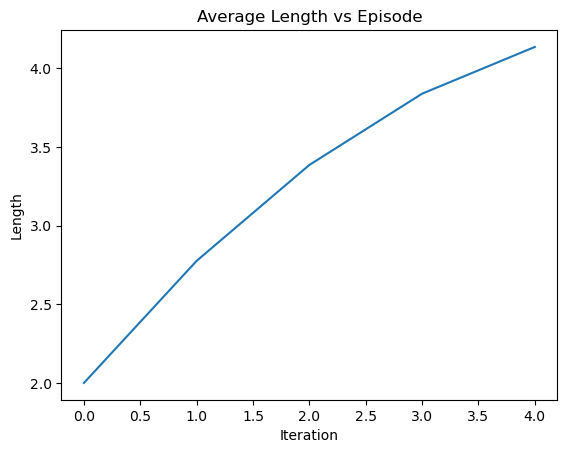

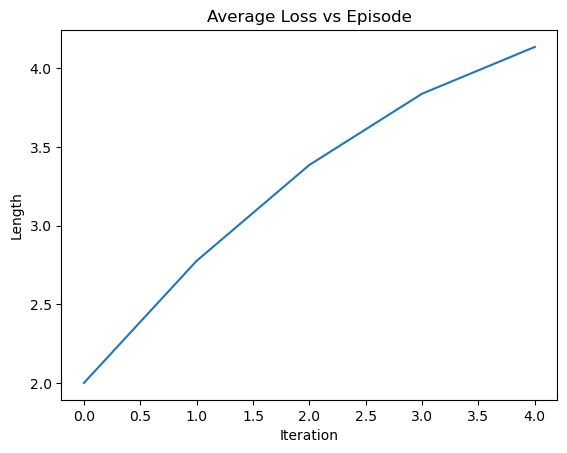

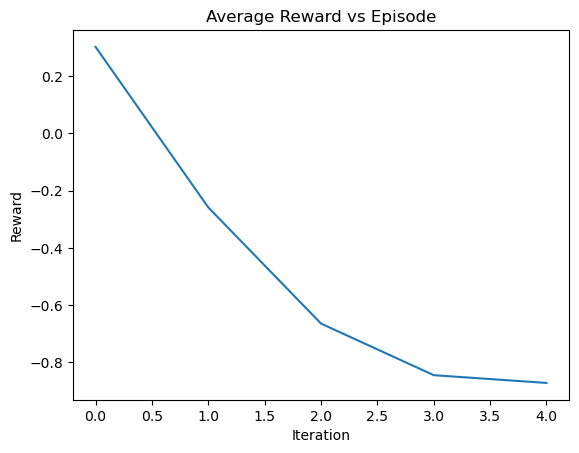

In [16]:
print(f"Trainable Parameters: {count_parameters(policy)}")
# TODO: last model
# TODO: iterations


plot_graphs(rewards, value_losses, lengths)